In [63]:
from tqdm import tqdm

import pickle
import os

import matplotlib.pyplot as plt

from dataset import *
from model import *

import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

path_save = './results/'

if not os.path.exists(path_save):
    os.makedirs(path_save)

Using cuda device


We first define some hyperparameters, load the data, create the model.

In [7]:
# Hyperparameters
lr = 1e-3
batch_size = 128
n_epochs = 10
num_layers = 6
d = 2

In [3]:
# Load the data
data_loader_train, data_loader_test, len_all_words, max_len, data_train, data_test, dic = load_data(batch_size = batch_size, path = "./IMDB.csv")
print("Data loaded")

Number of unique words:  101160
Maximum length of a review:  1416
Data loaded


In [4]:
# Create the model
model = CustomTransformer(num_words = len_all_words, d = d, num_layers = num_layers, beta = 1., share = False, value = "identity")
model.to(device)

CustomTransformer(
  (attention_layers): ModuleList(
    (0-5): 6 x SimpleAttention(
      (query): Linear(in_features=2, out_features=2, bias=False)
      (key): Linear(in_features=2, out_features=2, bias=False)
      (value): Linear(in_features=2, out_features=2, bias=False)
    )
  )
  (proj): Linear(in_features=2, out_features=1, bias=True)
)

We can then start training:

In [5]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [9]:
train_losses = []
test_losses = []
train_accu = []
test_accu = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_accuracy = 0
    total = 0
    for data, target in tqdm(data_loader_train, total = len(data_loader_train), desc = f'Epoch {epoch + 1}/{n_epochs}'):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_loss += loss.item()
            train_accuracy += ((output > 0.5) == target).sum().item()
            total += len(target)
    train_losses.append(train_loss / len(data_loader_train))
    train_accu.append(train_accuracy / total)

    model.eval()
    test_loss = 0
    test_accuracy = 0
    total = 0
    with torch.no_grad():
        for data, target in tqdm(data_loader_test, total = len(data_loader_test), desc = 'Test '):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target.float())
            test_loss += loss.item()
            test_accuracy += ((output > 0.5) == target).sum().item()
            total += len(target)
        test_losses.append(test_loss / len(data_loader_test))
        test_accu.append(test_accuracy / total)

    print(f'Epoch {epoch+1}, train_loss: {train_losses[-1]}, train_accu: {train_accu[-1]}, test_loss: {test_losses[-1]}, test_accu: {test_accu[-1]}')


Test : 100%|██████████| 118/118 [00:08<00:00, 13.87it/s]


Epoch 1, train_loss: 0.5382582143928013, train_accu: 0.7541428571428571, test_loss: 0.5344847362425368, test_accu: 0.752


Test : 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch 2, train_loss: 0.48300357478378464, train_accu: 0.7930285714285714, test_loss: 0.49723244546833684, test_accu: 0.7775333333333333


Test : 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch 3, train_loss: 0.4371739656385714, train_accu: 0.8192285714285714, test_loss: 0.46539586807711647, test_accu: 0.7945333333333333


Test : 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch 4, train_loss: 0.3979995848923704, train_accu: 0.8433428571428572, test_loss: 0.44012271524485896, test_accu: 0.8108666666666666


Test : 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch 5, train_loss: 0.3627815323807027, train_accu: 0.8624285714285714, test_loss: 0.42571996935343337, test_accu: 0.8193333333333334


Test : 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch 6, train_loss: 0.3341304427624619, train_accu: 0.8759714285714286, test_loss: 0.4147014484062033, test_accu: 0.8287333333333333


Test : 100%|██████████| 118/118 [00:08<00:00, 13.88it/s]


Epoch 7, train_loss: 0.30776435588180584, train_accu: 0.8894857142857143, test_loss: 0.41006669907246607, test_accu: 0.8336


Test : 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch 8, train_loss: 0.2846160814383604, train_accu: 0.9001142857142858, test_loss: 0.3911947594103167, test_accu: 0.8405333333333334


Test : 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch 9, train_loss: 0.2654577898283074, train_accu: 0.9111428571428571, test_loss: 0.39176486407296135, test_accu: 0.8446


Test : 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]

Epoch 10, train_loss: 0.24860797757214873, train_accu: 0.9186285714285715, test_loss: 0.4006336700108092, test_accu: 0.8452


In [64]:
# Save model and data

torch.save(model.state_dict(), os.path.join(path_save, 'model.pth'))
print('Model saved')

with open(os.path.join(path_save, 'results_training.pkl'), 'wb') as f:
    pickle.dump((train_losses, test_losses, train_accu, test_accu), f)
with open(os.path.join(path_save, 'embeddings.pkl'), 'wb') as f:
    pickle.dump((data_loader_train, data_loader_test, len_all_words, max_len, data_train, data_test, dic), f)

Model saved


Below the code allows to choose a review from the test dataset, and see the model's behavior.

In [19]:
indice = 5 # Choose
indice = data_test.index[indice]

data = data_test["word_index"][indice]
data += [len_all_words - 1] * (max_len - len(data))

target = data_test["sentiment"][indice]

review = data_test["review_clean"][indice]
print(data_test["review"][indice])

data = torch.tensor(data).unsqueeze(0).to(device)
output = model(data)
print("Output:", output.item(), "Target:", target)

print(f"Length of review = {len(review.split())}")
print(f"Length of review: {len([i for i in range(len(data[0])) if data[0][i] != data[0][-1]])}")

print(f"data.shape = {data.shape}")

I remember this film,it was the first film i had watched at the cinema the picture was dark in places i was very nervous it was back in 74/75 my Dad took me my brother & sister to Newbury cinema in Newbury Berkshire England. I recall the tigers and the lots of snow in the film also the appearance of Grizzly Adams actor Dan Haggery i think one of the tigers gets shot and dies. If anyone knows where to find this on DVD etc please let me know.The cinema now has been turned in a fitness club which is a very big shame as the nearest cinema now is 20 miles away, would love to hear from others who have seen this film or any other like it.
Output: 0.9562034010887146 Target: 1
Length of review = 63
Length of review: 63
data.shape = torch.Size([1, 1416])


We can also create our own review. In the next cell, we write a review that is both positive and negative.

In [46]:
review = "This movie is really bad I loved it it was great though it was terrible I would recommend it to everyone"
review = review.lower()
review = " ".join([word for word in review.split() if word in dic])

data = [dic[word] for word in review.split() if word in dic]
data = data[:max_len]
data += [len_all_words - 1] * (max_len - len(data))
data = torch.tensor(data).unsqueeze(0).to(device)
print(data)

output = model(data)
print("Output:", output.item())

tensor([[ 41471,  10089,  96082,  ..., 101160, 101160, 101160]],
       device='cuda:0')
Output: 0.5999946594238281


We see that the output of the model is typically about $0.6$: it is not sure whether it is positive or negative (but it would rather say positive).

Below, we plot the vectors in the plane for the first layer, and a deeper layer.

In [58]:
def plot_frame(list_index, indices, evolution):
    """
    Plot the evolution of the hidden states of the model for the given indices

    list_index: list of indices of the layers to plot
    indices: list of indices of the words to annotate
    evolution: tensor of shape (num_layers, num_words, 2)
    """
    plt.clf()

    n_columns = 2
    n_rows = len(list_index) // n_columns + 1

    plt.figure(figsize = (n_columns * 7, n_rows * 6))

    for i, index in enumerate(list_index):
        plt.subplot(n_rows, n_columns, i + 1)
        plt.scatter(evolution[index, :, 0], evolution[index, :, 1])

        # Annotate the points
        for k, j in enumerate(indices):
            txt = review.split(" ")[j]
            x, y = evolution[index, k, 0], evolution[index, k, 1]
            x, y = 1.2 * x, 1.2 * y
            plt.annotate(txt, (x, y))
        
        # Plot the unit circle
        theta = np.linspace(0, 2*np.pi, 100)
        x1 = np.cos(theta)
        x2 = np.sin(theta)
        plt.plot(x1, x2, 'k--', label='Unit circle')

        plt.title(f"Layer {index + 1}")
        
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)

        plt.gca().set_aspect('equal')

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

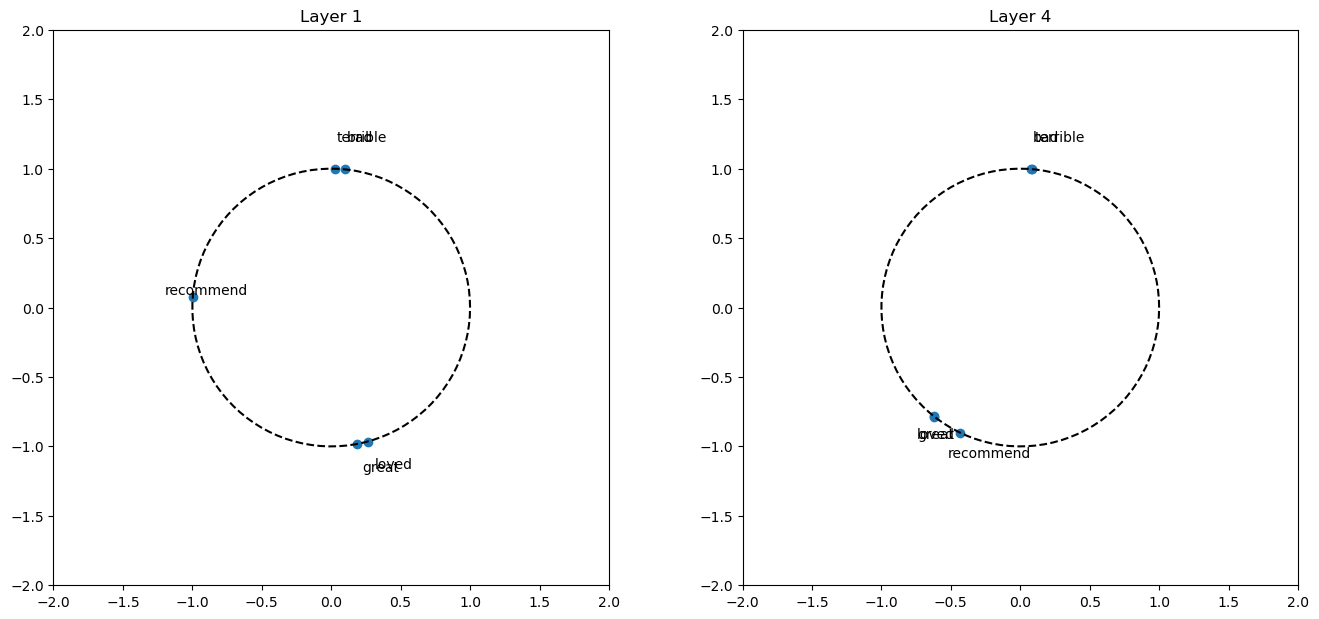

In [59]:
output, interm = model(data, True)
indices = [2, 3, 4, 6, 8]
evolution = [x[0, indices, :] for x in interm]
evolution = torch.stack(evolution, dim = 0)
evolution = evolution.detach().cpu().numpy()

plot_frame([0, 3], indices, evolution)

We see that the embedding is, as expected, doing a lot: "loved" and "great" are close to each other, so are "bad" and "terrible", while "recommend" is somewhere in-between.

But we see that self-attention pushes "recommend" towards "loved" and "great".